
#    Deep Learning Course 2019
######  Lecturer: Assistant prof. Siamak Mehrkanoon
####  =====================================================================================================

## Assignment-1:

### Download the Iris data and explore it, (visualize it, how many classes, instances, features, etc)
### Select feature number 0 and 2 and the first 100 samples and do the following analysis: 

### 1) Implement the logistic regression model that discussed in the class (with and without regularization). Use Gradient descent algorithm for updating the parameters. Plot the results.

### 2) Explore the influence of learning rate on the convergence of the model. Tune the learning rate.

### 3) Repeat steps 1-4 for different randomly selected features (e.g. 1 and 3 or 2 and 3) and compare the results.

### 4) Give the option to the users to select whatever combination of features they want and your code will do the rest.

### 5)  Try your model on Monk2 dataset and report the results, (test accuracy, training accuracy, optimal learning rate, loss value). Use the last 20% of the data as test.



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('seaborn-deep')

iris = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None)
iris.head()

,0,1,2,3,4
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


### Iris types count; all are equal to 50 and no missing values in columns

In [2]:
iris.info()
iris[4].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
0    150 non-null float64
1    150 non-null float64
2    150 non-null float64
3    150 non-null float64
4    150 non-null object
dtypes: float64(4), object(1)
memory usage: 5.9+ KB


Iris-virginica     50
Iris-setosa        50
Iris-versicolor    50
Name: 4, dtype: int64

### Target is created 

In [3]:
iris['target'] = iris.apply(lambda x: 0 if x[4] == 'Iris-setosa' else 1 if x[4] == 'Iris-versicolor' else 2, axis=1)
iris.head()
iris.target.value_counts()

2    50
1    50
0    50
Name: target, dtype: int64

### Variable distributions per target

In [4]:
def var_dist(data1, variable1): 
    
    setosa0 = data1[data1.target == 0]
    versicolor0 = data1[data1.target == 1]
    virginica0 = data1[data1.target == 2]
    
    #Variable distributions
    iris_all = data1[variable1]
    max1 = max(iris_all); 
    min1 = min(iris_all); 
    setosa = setosa0[variable1]
    versicolor = versicolor0[variable1]
    virginica = virginica0[variable1]

    bins = np.linspace(min1, max1, 30)

    plt.hist([setosa, versicolor, virginica], bins, label=['setosa_'+str(variable1), 'versicolor_'+str(variable1), 'virginica_'+str(variable1)])
    plt.legend(loc='upper right')
    plt.show()

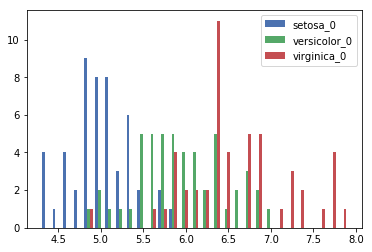

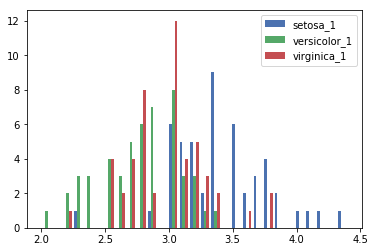

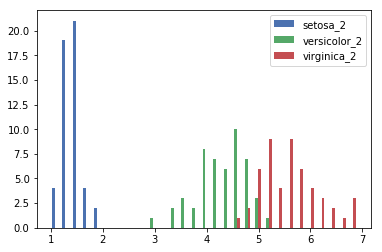

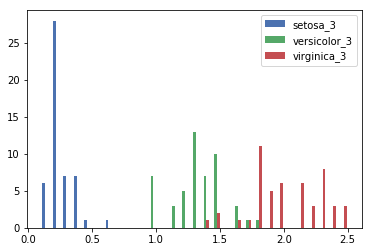

In [5]:
var_dist(iris, 0);
var_dist(iris, 1);
var_dist(iris, 2);
var_dist(iris, 3);

### Functions for Logistic Regression

In [6]:
#sigmoid function
def sigmoid(z):
    return 1/(1 + np.exp(-z))

#predicts probabilities based on theta (variable coefficients/betas) 
def predict(X, theta):
    X_2 = X.loc[:, X.columns != 'prob']
    z = np.dot(X_2, theta)
    h = sigmoid(z)
    X['prob'] = h
    return X

#calculates the loss function wrt log likelihood including L2 regularization
def loss_function(X, y, theta, row1, lambda1):
    theta_2 = np.sum(theta**2)
    return (-y * np.log(X.prob) - (1 - y) * np.log(1 - X.prob)).mean() + (0.5 * lambda1 / row1) * theta_2

#computes gradient in order to update theta including regularization
def gradient(X, y, theta, row1, lambda1):
    X_prob = X.prob
    X_2 = X.loc[:, X.columns != 'prob']
    return (1 / row1) * np.dot(X_2.T, (X_prob - y)) + ((lambda1 / row1) * theta)

#final classifications from those probabilities
def classify(X, threshold):
    X_prob = X.prob
    X_prediction = X_prob.map(lambda x: 1 if x >= threshold else 0)
    return X_prediction

#evaluation metrics
def metrics(y, X_pred):  
    df = pd.concat([y, X_pred], axis = 1)
    df1 = df.groupby(['target','prob']).size().unstack()
    df1 = df1.fillna(0)
    
    #predicted vs actual values 
    TP = df1.iloc[1][1]; 
    TN = df1.iloc[0][0];
    FN = df1.iloc[1][0];
    FP = df1.iloc[0][1]; 
    #how many observations are correctly classified? 
    accuracy = (TP+TN)/ (TP+TN+FN+FP)
    #among the observations predicted as positive, how many of them actual positive? 
    precision = TP / (TP+FP)
    #how many of them are covered of actual positives?
    recall = TP / (TP+FN)
    
    output = {'accuracy': accuracy, 'precision': precision, 'recall': recall}  
    return output

### Logistic Regression model

In [7]:
def Log_Reg(data1, var_list, num_iter, learning_rate, lambda1, threshold): 
    #data1 : training data
    #var_list: variables will be used in the model
    #num_iter: number of steps in gradient descent
    #learning_rate: step size
    #lambda1: regularization parameter
    #threshold: cut-off probability for final binary classification
    
    y = data1.target; X = data1[var_list]
    
    #normalization (needed for regularization)
    X_norm = (X-X.mean())/X.std()
    X_norm['bias'] = 1; #all set as 1 for bias term
    X_norm['prob'] = 0; #iteratively updated for final classification
    
    #number of rows and columns, and initialization of betas
    row1, col1 = X_norm.shape
    theta = np.zeros((col1-1))
    
    #gradient descent iterations
    for i in range(num_iter):
        
        X_norm = predict(X_norm, theta)
        loss = loss_function(X_norm, y, theta, row1, lambda1)
        print('loss: ', loss)
        grad = gradient(X_norm, y, theta, row1, lambda1)
        theta = theta - (learning_rate * grad)
        
    
    #classification with final theta
    X_pred = classify(X_norm, threshold)
    
    #model performance
    performance = metrics(y, X_pred)
    
    return X_pred, theta, performance

### Runs

In [8]:
iris_2 = iris.head(100) 
var_list = [0, 2]

#Run 1
#only 50 iterations with learning rate 0.001 and no regularization
X_pred, theta, performance = Log_Reg(iris_2, var_list, 50, 0.001, 0, 0.5);
theta
performance

loss:  0.6931471805599458
loss:  0.6927831338820327
loss:  0.6924194079179198
loss:  0.6920560023802814
loss:  0.6916929169818904
loss:  0.6913301514356107
loss:  0.6909677054544057
loss:  0.6906055787513331
loss:  0.6902437710395471
loss:  0.6898822820322995
loss:  0.6895211114429415
loss:  0.6891602589849206
loss:  0.6887997243717854
loss:  0.6884395073171834
loss:  0.6880796075348609
loss:  0.6877200247386674
loss:  0.687360758642553
loss:  0.6870018089605684
loss:  0.6866431754068693
loss:  0.6862848576957119
loss:  0.6859268555414575
loss:  0.6855691686585713
loss:  0.6852117967616228
loss:  0.6848547395652883
loss:  0.6844979967843473
loss:  0.6841415681336876
loss:  0.6837854533283039
loss:  0.6834296520832974
loss:  0.6830741641138779
loss:  0.6827189891353637
loss:  0.6823641268631819
loss:  0.6820095770128701
loss:  0.6816553393000743
loss:  0.6813014134405531
loss:  0.6809477991501747
loss:  0.6805944961449208
loss:  0.6802415041408837
loss:  0.6798888228542691
loss:  0.6795

{'accuracy': 0.96, 'precision': 1.0, 'recall': 0.92}

In [9]:
#Run 2
#500 iterations with learning rate 0.001 and no regularization
X_pred, theta, performance = Log_Reg(iris_2, var_list, 500, 0.001, 0, 0.5);
theta
performance

loss:  0.6931471805599458
loss:  0.6927831338820327
loss:  0.6924194079179198
loss:  0.6920560023802814
loss:  0.6916929169818904
loss:  0.6913301514356107
loss:  0.6909677054544057
loss:  0.6906055787513331
loss:  0.6902437710395471
loss:  0.6898822820322995
loss:  0.6895211114429415
loss:  0.6891602589849206
loss:  0.6887997243717854
loss:  0.6884395073171834
loss:  0.6880796075348609
loss:  0.6877200247386674
loss:  0.687360758642553
loss:  0.6870018089605684
loss:  0.6866431754068693
loss:  0.6862848576957119
loss:  0.6859268555414575
loss:  0.6855691686585713
loss:  0.6852117967616228
loss:  0.6848547395652883
loss:  0.6844979967843473
loss:  0.6841415681336876
loss:  0.6837854533283039
loss:  0.6834296520832974
loss:  0.6830741641138779
loss:  0.6827189891353637
loss:  0.6823641268631819
loss:  0.6820095770128701
loss:  0.6816553393000743
loss:  0.6813014134405531
loss:  0.6809477991501747
loss:  0.6805944961449208
loss:  0.6802415041408837
loss:  0.6798888228542691
loss:  0.6795

loss:  0.5820215761337943
loss:  0.5817543244212847
loss:  0.581487300511132
loss:  0.5812205041733052
loss:  0.5809539351779686
loss:  0.5806875932954848
loss:  0.580421478296413
loss:  0.5801555899515077
loss:  0.5798899280317219
loss:  0.5796244923082046
loss:  0.5793592825523022
loss:  0.5790942985355576
loss:  0.5788295400297111
loss:  0.5785650068066999
loss:  0.5783006986386581
loss:  0.5780366152979173
loss:  0.577772756557007
loss:  0.5775091221886512
loss:  0.5772457119657743
loss:  0.576982525661497
loss:  0.5767195630491362
loss:  0.5764568239022078
loss:  0.5761943079944236
loss:  0.5759320150996942
loss:  0.5756699449921264
loss:  0.5754080974460255
loss:  0.5751464722358942
loss:  0.574885069136432
loss:  0.5746238879225364
loss:  0.5743629283693037
loss:  0.5741021902520255
loss:  0.5738416733461928
loss:  0.5735813774274938
loss:  0.5733213022718147
loss:  0.5730614476552389
loss:  0.5728018133540481
loss:  0.572542399144721
loss:  0.5722832048039352
loss:  0.572024230

{'accuracy': 0.96, 'precision': 1.0, 'recall': 0.92}

In [10]:
#Run 3
#500 iterations with learning rate increased to 0.01 and no regularization 
#Improved!
X_pred, theta, performance = Log_Reg(iris_2, var_list, 500, 0.01, 0, 0.5);
theta
performance

loss:  0.6931471805599458
loss:  0.689513933040388
loss:  0.6859126271661131
loss:  0.6823429755563329
loss:  0.6788046918679628
loss:  0.6752974908508801
loss:  0.671821088401238
loss:  0.6683752016128526
loss:  0.6649595488266901
loss:  0.66157384967846
loss:  0.6582178251443487
loss:  0.6548911975849081
loss:  0.6515936907871287
loss:  0.6483250300047168
loss:  0.64508494199661
loss:  0.6418731550637485
loss:  0.6386893990841415
loss:  0.635533405546245
loss:  0.6324049075806967
loss:  0.6293036399904188
loss:  0.6262293392791412
loss:  0.6231817436783579
loss:  0.6201605931727612
loss:  0.6171656295241783
loss:  0.614196596294051
loss:  0.6112532388644809
loss:  0.608335304457882
loss:  0.6054425421552742
loss:  0.6025747029132414
loss:  0.5997315395795997
loss:  0.5969128069078008
loss:  0.5941182615701074
loss:  0.5913476621695748
loss:  0.5886007692508672
loss:  0.5858773453099468
loss:  0.5831771548026654
loss:  0.5804999641522948
loss:  0.5778455417560171
loss:  0.575213657990

loss:  0.2575972252575856
loss:  0.2571360563798275
loss:  0.25667684180406897
loss:  0.25621956900767373
loss:  0.2557642255726565
loss:  0.2553107991846249
loss:  0.2548592776317331
loss:  0.2544096488036471
loss:  0.2539619006905229
loss:  0.25351602138199597
loss:  0.25307199906618305
loss:  0.25262982202869455
loss:  0.2521894786516594
loss:  0.2517509574127608
loss:  0.25131424688428255
loss:  0.2508793357321675
loss:  0.25044621271508577
loss:  0.2500148666835146
loss:  0.24958528657882761
loss:  0.24915746143239645
loss:  0.24873138036469966
loss:  0.2483070325844456
loss:  0.24788440738770176
loss:  0.24746349415703658
loss:  0.24704428236067005
loss:  0.24662676155163296
loss:  0.24621092136693817
loss:  0.24579675152675906
loss:  0.2453842418336183
loss:  0.24497338217158532
loss:  0.24456416250548366
loss:  0.24415657288010642
loss:  0.24375060341944102
loss:  0.24334624432590207
loss:  0.24294348587957412
loss:  0.24254231843746132
loss:  0.24214273243274664
loss:  0.24174

{'accuracy': 0.97, 'precision': 1.0, 'recall': 0.94}

In [11]:
#Run 4
#1000 iterations with learning rate increased to 0.01 and no regularization
X_pred, theta, performance = Log_Reg(iris_2, var_list, 1000, 0.01, 0, 0.5);
theta
performance

loss:  0.6931471805599458
loss:  0.689513933040388
loss:  0.6859126271661131
loss:  0.6823429755563329
loss:  0.6788046918679628
loss:  0.6752974908508801
loss:  0.671821088401238
loss:  0.6683752016128526
loss:  0.6649595488266901
loss:  0.66157384967846
loss:  0.6582178251443487
loss:  0.6548911975849081
loss:  0.6515936907871287
loss:  0.6483250300047168
loss:  0.64508494199661
loss:  0.6418731550637485
loss:  0.6386893990841415
loss:  0.635533405546245
loss:  0.6324049075806967
loss:  0.6293036399904188
loss:  0.6262293392791412
loss:  0.6231817436783579
loss:  0.6201605931727612
loss:  0.6171656295241783
loss:  0.614196596294051
loss:  0.6112532388644809
loss:  0.608335304457882
loss:  0.6054425421552742
loss:  0.6025747029132414
loss:  0.5997315395795997
loss:  0.5969128069078008
loss:  0.5941182615701074
loss:  0.5913476621695748
loss:  0.5886007692508672
loss:  0.5858773453099468
loss:  0.5831771548026654
loss:  0.5804999641522948
loss:  0.5778455417560171
loss:  0.575213657990

loss:  0.2613584692633886
loss:  0.2608812022370538
loss:  0.26040599359253247
loss:  0.259932829930321
loss:  0.259461697964503
loss:  0.2589925845215847
loss:  0.258525476539346
loss:  0.258060361065703
loss:  0.2575972252575856
loss:  0.2571360563798275
loss:  0.25667684180406897
loss:  0.25621956900767373
loss:  0.2557642255726565
loss:  0.2553107991846249
loss:  0.2548592776317331
loss:  0.2544096488036471
loss:  0.2539619006905229
loss:  0.25351602138199597
loss:  0.25307199906618305
loss:  0.25262982202869455
loss:  0.2521894786516594
loss:  0.2517509574127608
loss:  0.25131424688428255
loss:  0.2508793357321675
loss:  0.25044621271508577
loss:  0.2500148666835146
loss:  0.24958528657882761
loss:  0.24915746143239645
loss:  0.24873138036469966
loss:  0.2483070325844456
loss:  0.24788440738770176
loss:  0.24746349415703658
loss:  0.24704428236067005
loss:  0.24662676155163296
loss:  0.24621092136693817
loss:  0.24579675152675906
loss:  0.2453842418336183
loss:  0.2449733821715853

loss:  0.16317855955821764
loss:  0.16302663251631352
loss:  0.16287505519874249
loss:  0.16272382633368185
loss:  0.16257294465553662
loss:  0.16242240890490092
loss:  0.16227221782852022
loss:  0.1621223701792538
loss:  0.16197286471603822
loss:  0.16182370020384937
loss:  0.1616748754136665
loss:  0.16152638912243553
loss:  0.16137824011303273
loss:  0.16123042717422945
loss:  0.16108294910065576
loss:  0.1609358046927655
loss:  0.16078899275680103
loss:  0.16064251210475844
loss:  0.16049636155435285
loss:  0.16035053992898404
loss:  0.16020504605770236
loss:  0.1600598787751749
loss:  0.15991503692165196
loss:  0.15977051934293324
loss:  0.1596263248903349
loss:  0.15948245242065714
loss:  0.1593389007961507
loss:  0.15919566888448475
loss:  0.15905275555871504
loss:  0.15891015969725103
loss:  0.1587678801838252
loss:  0.15862591590746056
loss:  0.15848426576243993
loss:  0.15834292864827462
loss:  0.15820190346967367
loss:  0.1580611891365128
loss:  0.15792078456380448
loss:  0.

{'accuracy': 0.97, 'precision': 1.0, 'recall': 0.94}

In [12]:
#Run 5
#100 iterations with learning rate increased to 0.05 and no regularization
X_pred, theta, performance = Log_Reg(iris_2, var_list, 100, 0.05, 0, 0.5);
theta
performance

loss:  0.6931471805599458
loss:  0.6751413504970758
loss:  0.6579194422361209
loss:  0.6414456239017717
loss:  0.625684943682215
loss:  0.6106034565081092
loss:  0.5961683230865492
loss:  0.58234788381458
loss:  0.5691117102726247
loss:  0.5564306370470162
loss:  0.5442767765799748
loss:  0.5326235196202876
loss:  0.5214455236714666
loss:  0.510718691625483
loss:  0.5004201425451403
loss:  0.4905281763288555
loss:  0.4810222337673116
loss:  0.4718828532884624
loss:  0.46309162548990523
loss:  0.45463114637812146
loss:  0.4464849700734949
loss:  0.43863756159844636
loss:  0.4310742502427449
loss:  0.42378118389394837
loss:  0.4167452846305708
loss:  0.4099542057994205
loss:  0.4033962907349869
loss:  0.3970605332262698
loss:  0.39093653979353077
loss:  0.3850144938027853
loss:  0.37928512141820414
loss:  0.3737396593708688
loss:  0.3683698245055618
loss:  0.36316778505464525
loss:  0.3581261335788396
loss:  0.35323786150827857
loss:  0.34849633521302487
loss:  0.34389527352985605
loss: 

{'accuracy': 0.97, 'precision': 1.0, 'recall': 0.94}

In [13]:
#Run 6
#500 iterations with learning rate increased to 0.05 and no regularization 
#Improved
X_pred, theta, performance = Log_Reg(iris_2, var_list, 500, 0.05, 0, 0.5);
theta
performance

loss:  0.6931471805599458
loss:  0.6751413504970758
loss:  0.6579194422361209
loss:  0.6414456239017717
loss:  0.625684943682215
loss:  0.6106034565081092
loss:  0.5961683230865492
loss:  0.58234788381458
loss:  0.5691117102726247
loss:  0.5564306370470162
loss:  0.5442767765799748
loss:  0.5326235196202876
loss:  0.5214455236714666
loss:  0.510718691625483
loss:  0.5004201425451403
loss:  0.4905281763288555
loss:  0.4810222337673116
loss:  0.4718828532884624
loss:  0.46309162548990523
loss:  0.45463114637812146
loss:  0.4464849700734949
loss:  0.43863756159844636
loss:  0.4310742502427449
loss:  0.42378118389394837
loss:  0.4167452846305708
loss:  0.4099542057994205
loss:  0.4033962907349869
loss:  0.3970605332262698
loss:  0.39093653979353077
loss:  0.3850144938027853
loss:  0.37928512141820414
loss:  0.3737396593708688
loss:  0.3683698245055618
loss:  0.36316778505464525
loss:  0.3581261335788396
loss:  0.35323786150827857
loss:  0.34849633521302487
loss:  0.34389527352985605
loss: 

loss:  0.08554200631036603
loss:  0.08538663733599679
loss:  0.08523194142706
loss:  0.08507791381847257
loss:  0.08492454979180013
loss:  0.08477184467467813
loss:  0.0846197938402419
loss:  0.08446839270656419
loss:  0.08431763673610213
loss:  0.0841675214351519
loss:  0.08401804235331145
loss:  0.08386919508295147
loss:  0.08372097525869383
loss:  0.08357337855689789
loss:  0.08342640069515436
loss:  0.08328003743178637
loss:  0.0831342845653582
loss:  0.08298913793419053
loss:  0.0828445934158836
loss:  0.08270064692684638
loss:  0.08255729442183327
loss:  0.08241453189348702
loss:  0.08227235537188844
loss:  0.0821307609241125
loss:  0.08198974465379091
loss:  0.08184930270068051
loss:  0.08170943124023845
loss:  0.081570126483203
loss:  0.08143138467518041
loss:  0.08129320209623747
loss:  0.08115557506049996
loss:  0.08101849991575694
loss:  0.08088197304307004
loss:  0.08074599085638873
loss:  0.08061054980217096
loss:  0.0804756463590085
loss:  0.08034127703725835
loss:  0.080

{'accuracy': 0.99, 'precision': 1.0, 'recall': 0.98}

In [14]:
#Run 7
#500 iterations with learning rate increased to 0.05 and regularization term as 1
X_pred, theta, performance = Log_Reg(iris_2, var_list, 500, 0.05, 1, 0.5);
theta
performance

loss:  0.6931471805599458
loss:  0.6751459020832293
loss:  0.6579459478052844
loss:  0.6415099482450771
loss:  0.6258015245629016
loss:  0.6107854116886768
loss:  0.5964275529480029
loss:  0.582695168944935
loss:  0.569556803608692
loss:  0.5569823503308253
loss:  0.5449430610389241
loss:  0.5334115408996946
loss:  0.522361731141957
loss:  0.511768882258544
loss:  0.501609519601253
loss:  0.491861403137131
loss:  0.4825034828963762
loss:  0.4735158514182234
loss:  0.46487969429516107
loss:  0.45657723972979464
loss:  0.4485917078533253
loss:  0.4409072604096756
loss:  0.4335089512838242
loss:  0.4263826782455019
loss:  0.41951513618846165
loss:  0.41289377206932626
loss:  0.4065067416867809
loss:  0.40034286839000893
loss:  0.3943916037631683
loss:  0.3886429902989405
loss:  0.38308762604756097
loss:  0.37771663120697313
loss:  0.37252161660404165
loss:  0.36749465400506076
loss:  0.36262824818552486
loss:  0.35791531068355076
loss:  0.3533491351579859
loss:  0.3489233742706288
loss:  

{'accuracy': 0.99, 'precision': 1.0, 'recall': 0.98}

In [16]:
#Run 8
#500 iterations with learning rate increased to 0.05 and regularization term as 10
#Worsened
X_pred, theta, performance = Log_Reg(iris_2, var_list, 500, 0.05, 10, 0.5);
theta
performance

loss:  0.6931471805599458
loss:  0.6751868663586112
loss:  0.658183693291772
loss:  0.6420849862188802
loss:  0.6268402667315132
loss:  0.6124013215684029
loss:  0.5987222360276153
loss:  0.5857593975147538
loss:  0.5734714741562369
loss:  0.561819373069506
loss:  0.5507661824644972
loss:  0.5402771012912866
loss:  0.5303193596775588
loss:  0.5208621329385338
loss:  0.5118764515066061
loss:  0.5033351087278934
loss:  0.4952125681134059
loss:  0.4874848713156504
loss:  0.4801295478266277
loss:  0.4731255271583339
loss:  0.46645305406894455
loss:  0.46009360723319304
loss:  0.4540298216202157
loss:  0.44824541473255164
loss:  0.4427251167723797
loss:  0.43745460473218367
loss:  0.43242044035379124
loss:  0.42761001185952574
loss:  0.4230114793296887
loss:  0.41861372357979965
loss:  0.4144062983772308
loss:  0.41037938582869327
loss:  0.4065237547662459
loss:  0.40283072195913416
loss:  0.3992921159809957
loss:  0.3959002435661838
loss:  0.39264785829453147
loss:  0.38952813145049625
los

{'accuracy': 0.97, 'precision': 1.0, 'recall': 0.94}

### Different variable combinations

In [17]:
var_list = [1, 3]

#Run 9
#500 iterations with learning rate increased to 0.05 and regularization term as 1 
#Better than 0 and 2
X_pred, theta, performance = Log_Reg(iris_2, var_list, 500, 0.05, 1, 0.5);
theta
performance

loss:  0.6931471805599458
loss:  0.6761156295779249
loss:  0.6597389809530554
loss:  0.6439910432336229
loss:  0.6288462234775554
loss:  0.6142795903443939
loss:  0.6002669246757167
loss:  0.5867847585654798
loss:  0.573810403984191
loss:  0.5613219720448679
loss:  0.5492983839912499
loss:  0.5377193749563582
loss:  0.5265654914884615
loss:  0.5158180837772088
loss:  0.5054592934399115
loss:  0.49547203765056835
loss:  0.4858399903154083
loss:  0.4765475609209288
loss:  0.46757987160543685
loss:  0.4589227329342726
loss:  0.4505626187930676
loss:  0.44248664075300387
loss:  0.4346825222073585
loss:  0.4271385725295913
loss:  0.41984366145970625
loss:  0.4127871938873126
loss:  0.4059590851663813
loss:  0.39934973706772264
loss:  0.39295001445034367
loss:  0.3867512227115984
loss:  0.3807450860580817
loss:  0.37492372662413076
loss:  0.3692796444522299
loss:  0.36380569833925763
loss:  0.3584950875440628
loss:  0.353341334345033
loss:  0.34833826743091445
loss:  0.34348000610392593
loss

loss:  0.10266784578250439
loss:  0.10258215896873643
loss:  0.10249708948791006
loss:  0.10241263177237125
loss:  0.10232878031671809
loss:  0.102245529676958
loss:  0.10216287446967814
loss:  0.10208080937122907
loss:  0.10199932911692143
loss:  0.10191842850023518
loss:  0.10183810237204184
loss:  0.10175834563983834
loss:  0.10167915326699364
loss:  0.10160052027200639
loss:  0.1015224417277752
loss:  0.10144491276087929
loss:  0.10136792855087101
loss:  0.10129148432957943
loss:  0.10121557538042417
loss:  0.10114019703774027
loss:  0.10106534468611365
loss:  0.10099101375972616
loss:  0.1009171997417115
loss:  0.1008438981635203
loss:  0.10077110460429527
loss:  0.10069881469025613
loss:  0.10062702409409321
loss:  0.1005557285343709
loss:  0.10048492377493973
loss:  0.10041460562435765
loss:  0.1003447699353198
loss:  0.10027541260409698
loss:  0.10020652956998252
loss:  0.10013811681474721
loss:  0.10007017036210289
loss:  0.10000268627717362
loss:  0.0999356606659746
loss:  0.

{'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0}

In [18]:
var_list = [2, 3]

#Run 10
#500 iterations with learning rate increased to 0.05 and regularization term as 1 
#Also, better than 0 and 2
#It can be seen that on its distribution graph, variable 3 looks better than 3 in order to diversify versicolor and virginica
X_pred, theta, performance = Log_Reg(iris_2, var_list, 500, 0.05, 1, 0.5);
theta
performance

loss:  0.6931471805599458
loss:  0.6703840384606014
loss:  0.6487437331875171
loss:  0.6281691781089037
loss:  0.6086050793544177
loss:  0.5899981097904037
loss:  0.5722970351040223
loss:  0.5554527976527538
loss:  0.5394185637345538
loss:  0.5241497397396878
loss:  0.5096039623135923
loss:  0.4957410672389307
loss:  0.4825230412737323
loss:  0.4699139606923688
loss:  0.4578799197904109
loss:  0.44638895214990065
loss:  0.43541094702917404
loss:  0.4249175628477086
loss:  0.41488213938452734
loss:  0.40527960999900337
loss:  0.3960864149141416
loss:  0.38728041637210164
loss:  0.37884081627664373
loss:  0.3707480767737794
loss:  0.3629838440865598
loss:  0.35553087580902565
loss:  0.34837297177459703
loss:  0.3414949085423852
loss:  0.33488237748842103
loss:  0.3285219264449954
loss:  0.322400904798173
loss:  0.3165074119290856
loss:  0.3108302488673012
loss:  0.30535887301302955
loss:  0.30008335577797784
loss:  0.29499434299140864
loss:  0.29008301791752933
loss:  0.28534106673213344

loss:  0.08618237513969865
loss:  0.08609842355198984
loss:  0.08601515487019881
loss:  0.08593256207080797
loss:  0.08585063822066219
loss:  0.08576937647555227
loss:  0.08568877007882583
loss:  0.08560881236002277
loss:  0.08552949673353649
loss:  0.08545081669729952
loss:  0.08537276583149331
loss:  0.0852953377972818
loss:  0.08521852633556778
loss:  0.08514232526577184
loss:  0.08506672848463379
loss:  0.08499172996503541
loss:  0.08491732375484465
loss:  0.0848435039757803
loss:  0.08477026482229742
loss:  0.08469760056049225
loss:  0.08462550552702695
loss:  0.08455397412807335
loss:  0.08448300083827517
loss:  0.08441258019972928
loss:  0.08434270682098369
loss:  0.08427337537605464
loss:  0.08420458060345952
loss:  0.08413631730526773
loss:  0.08406858034616743
loss:  0.08400136465254868
loss:  0.08393466521160281
loss:  0.08386847707043658
loss:  0.08380279533520249
loss:  0.08373761517024345
loss:  0.0836729317972522
loss:  0.08360874049444529
loss:  0.08354503659575084
loss

{'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0}

### Monk2 dataset 

In [19]:
from mat4py import loadmat
monk2 = loadmat('monk2.mat')
         
monk22 = pd.DataFrame(monk2)       

monk222 = pd.DataFrame(monk22.monk2.tolist(), columns=['var1', 'var2', 'var3', 'var4', 'var5', 'var6', 'target'])  

row1, col1 = monk222.shape         

head1 = round(row1*0.8)
    
monk_train = monk222.head(head1)

monk_test = monk222.tail(row1 - head1).reset_index(drop=True)

In [20]:
monk222.head()
monk_test.head()

,var1,var2,var3,var4,var5,var6,target
0,3,3,1,1,3,2,1
1,3,3,1,1,4,1,0
2,3,3,1,2,1,1,0
3,3,3,1,2,1,2,0
4,3,3,1,2,2,1,0


In [21]:
monk222.target.value_counts()

1    228
0    204
Name: target, dtype: int64

In [59]:
monk_train.target.value_counts()

1    202
0    144
Name: target, dtype: int64

In [54]:
monk_test.target.value_counts()
#Target values are not well stratified in train and test set

0    60
1    26
Name: target, dtype: int64

### Evaluation on test data

In [22]:
def evaluate_test(test_data, theta, var_list, threshold):
    
    y = test_data.target; X = test_data[var_list]
    
    #normalization (needed for regularization)
    X_norm = (X-X.mean())/X.std()
    X_norm['bias'] = 1;
    X_norm['prob'] = 0;
    
    X_prob = predict(X_norm, theta)
    test_prediction = classify(X_prob, threshold)
    test_output = metrics(y, test_prediction)
    
    return test_prediction, test_output

### Training

In [23]:
var_list = ['var1', 'var2', 'var3', 'var4', 'var5', 'var6']  

#Run 1
#No regularization 
X_pred, theta, performance = Log_Reg(monk_train, var_list, 500, 0.01, 0, 0.5)
performance
#Not very good

loss:  0.6931471805599467
loss:  0.6919409538333071
loss:  0.6907410795815149
loss:  0.6895475235016297
loss:  0.6883602513860136
loss:  0.6871792291240522
loss:  0.6860044227038572
loss:  0.6848357982139174
loss:  0.6836733218447126
loss:  0.6825169598902876
loss:  0.6813666787497848
loss:  0.680222444928944
loss:  0.6790842250415576
loss:  0.6779519858108868
loss:  0.6768256940710463
loss:  0.675705316768346
loss:  0.6745908209625945
loss:  0.6734821738283733
loss:  0.6723793426562643
loss:  0.671282294854048
loss:  0.6701909979478639
loss:  0.6691054195833366
loss:  0.6680255275266638
loss:  0.6669512896656752
loss:  0.6658826740108508
loss:  0.6648196486963107
loss:  0.663762181980767
loss:  0.6627102422484479
loss:  0.6616637980099822
loss:  0.6606228179032615
loss:  0.6595872706942608
loss:  0.6585571252778302
loss:  0.6575323506784648
loss:  0.6565129160510275
loss:  0.6554987906814559
loss:  0.6544899439874347
loss:  0.6534863455190354
loss:  0.6524879649593336
loss:  0.6514947

loss:  0.49209769317531077
loss:  0.4918395575732496
loss:  0.49158234220266944
loss:  0.4913260425863516
loss:  0.4910706542740907
loss:  0.49081617284251117
loss:  0.49056259389487755
loss:  0.49030991306091454
loss:  0.4900581259966173
loss:  0.4898072283840782
loss:  0.48955721593129775
loss:  0.48930808437201095
loss:  0.48905982946550974
loss:  0.4888124469964613
loss:  0.4885659327747388
loss:  0.48832028263524546
loss:  0.4880754924377399
loss:  0.487831558066668
loss:  0.48758847543099154
loss:  0.48734624046401975
loss:  0.4871048491232399
loss:  0.48686429739015474
loss:  0.48662458127011554
loss:  0.48638569679215676
loss:  0.4861476400088363
loss:  0.48591040699607413
loss:  0.4856739938529886
loss:  0.4854383967017404
loss:  0.48520361168737747
loss:  0.48496963497766993
loss:  0.4847364627629648
loss:  0.4845040912560234
loss:  0.48427251669187504
loss:  0.48404173532765893
loss:  0.48381174344247907
loss:  0.4835825373372482
loss:  0.4833541133345454
loss:  0.4831264677

{'accuracy': 0.8005780346820809,
 'precision': 0.821256038647343,
 'recall': 0.8415841584158416}

In [62]:
#test performance
#Poorer!
test_prediction, test_output = evaluate_test(monk_test, theta, var_list, 0.5)
test_output

{'accuracy': 0.6511627906976745,
 'precision': 0.46,
 'recall': 0.8846153846153846}

In [63]:
#Run 2
#number of iteration is increased and regularization term is set as 1
X_pred, theta, performance = Log_Reg(monk_train, var_list, 5000, 0.01, 1, 0.5)
performance

loss:  0.6931471805599467
loss:  0.6919409712873409
loss:  0.6907411839358889
loss:  0.6895477834667657
loss:  0.6883607349424611
loss:  0.6871800035284966
loss:  0.6860055544951081
loss:  0.6848373532188776
loss:  0.6836753651843301
loss:  0.6825195559854917
loss:  0.6813698913274013
loss:  0.6802263370275907
loss:  0.6790888590175167
loss:  0.677957423343961
loss:  0.6768319961703897
loss:  0.6757125437782713
loss:  0.674599032568363
loss:  0.6734914290619503
loss:  0.6723896999020629
loss:  0.671293811854638
loss:  0.6702037318096616
loss:  0.6691194267822651
loss:  0.668040863913787
loss:  0.6669680104728082
loss:  0.6659008338561361
loss:  0.6648393015897744
loss:  0.6637833813298415
loss:  0.6627330408634672
loss:  0.6616882481096507
loss:  0.6606489711200879
loss:  0.6596151780799656
loss:  0.6585868373087242
loss:  0.6575639172607919
loss:  0.6565463865262824
loss:  0.6555342138316688
loss:  0.6545273680404206
loss:  0.6535258181536177
loss:  0.6525295333105319
loss:  0.6515384

loss:  0.48686858561070956
loss:  0.4866399250906477
loss:  0.48641206648199353
loss:  0.48618500598435693
loss:  0.48595873981976745
loss:  0.4857332642325285
loss:  0.48550857548905746
loss:  0.48528466987774027
loss:  0.4850615437087791
loss:  0.48483919331404135
loss:  0.48461761504691564
loss:  0.4843968052821615
loss:  0.48417676041576474
loss:  0.483957476864795
loss:  0.4837389510672567
loss:  0.48352117948195455
loss:  0.4833041585883438
loss:  0.4830878848863956
loss:  0.4828723548964552
loss:  0.4826575651591026
loss:  0.4824435122350199
loss:  0.4822301927048497
loss:  0.48201760316906234
loss:  0.48180574024782347
loss:  0.48159460058085557
loss:  0.4813841808273117
loss:  0.48117447766563953
loss:  0.48096548779345627
loss:  0.4807572079274116
loss:  0.48054963480306845
loss:  0.4803427651747677
loss:  0.480136595815507
loss:  0.4799311235168144
loss:  0.47972634508862005
loss:  0.47952225735913634
loss:  0.4793188571747366
loss:  0.4791161413998281
loss:  0.4789141069167

loss:  0.4362315717219252
loss:  0.4361539049433728
loss:  0.43607642497214794
loss:  0.4359991312099137
loss:  0.4359220230607813
loss:  0.4358450999313001
loss:  0.4357683612304443
loss:  0.43569180636959864
loss:  0.4356154347625505
loss:  0.4355392458254746
loss:  0.435463238976924
loss:  0.4353874136378142
loss:  0.435311769231417
loss:  0.43523630518334344
loss:  0.43516102092153475
loss:  0.4350859158762537
loss:  0.43501098948006545
loss:  0.4349362411678335
loss:  0.43486167037670626
loss:  0.4347872765461034
loss:  0.4347130591177064
loss:  0.43463901753545015
loss:  0.43456515124550676
loss:  0.4344914596962765
loss:  0.43441794233837977
loss:  0.43434459862464214
loss:  0.4342714280100847
loss:  0.43419842995191676
loss:  0.4341256039095193
loss:  0.4340529493444379
loss:  0.43398046572037235
loss:  0.43390815250316445
loss:  0.43383600916078857
loss:  0.43376403516334344
loss:  0.43369222998303586
loss:  0.43362059309417555
loss:  0.43354912397316575
loss:  0.4334778220984

loss:  0.4086937626420482
loss:  0.4086723741307626
loss:  0.4086510209626464
loss:  0.4086297030649701
loss:  0.40860842036519157
loss:  0.4085871727909539
loss:  0.4085659602700849
loss:  0.4085447827305976
loss:  0.4085236401006867
loss:  0.408502532308733
loss:  0.40848145928329843
loss:  0.40846042095312707
loss:  0.4084394172471444
loss:  0.4084184480944573
loss:  0.4083975134243533
loss:  0.4083766131662997
loss:  0.4083557472499424
loss:  0.40833491560510654
loss:  0.4083141181617954
loss:  0.4082933548501907
loss:  0.40827262560064986
loss:  0.4082519303437075
loss:  0.40823126901007434
loss:  0.4082106415306373
loss:  0.40819004783645624
loss:  0.4081694878587678
loss:  0.4081489615289798
loss:  0.40812846877867626
loss:  0.4081080095396116
loss:  0.408087583743714
loss:  0.40806719132308306
loss:  0.4080468322099885
loss:  0.40802650633687215
loss:  0.40800621363634465
loss:  0.40798595404118815
loss:  0.40796572748435117
loss:  0.40794553389895455
loss:  0.40792537321828265

loss:  0.4004816300814848
loss:  0.40047269504150607
loss:  0.4004637722440159
loss:  0.4004548616691445
loss:  0.4004459632970609
loss:  0.4004370771079733
loss:  0.400428203082128
loss:  0.4004193411998093
loss:  0.40041049144134094
loss:  0.40040165378708464
loss:  0.4003928282174397
loss:  0.40038401471284407
loss:  0.40037521325377434
loss:  0.4003664238207432
loss:  0.40035764639430377
loss:  0.4003488809550454
loss:  0.40034012748359465
loss:  0.4003313859606168
loss:  0.4003226563668145
loss:  0.4003139386829274
loss:  0.40030523288973263
loss:  0.40029653896804457
loss:  0.4002878568987151
loss:  0.4002791866626324
loss:  0.4002705282407226
loss:  0.40026188161394827
loss:  0.4002532467633091
loss:  0.40024462366984
loss:  0.4002360123146157
loss:  0.40022741267874395
loss:  0.40021882474337234
loss:  0.4002102484896812
loss:  0.4002016838988907
loss:  0.40019313095225506
loss:  0.40018458963106573
loss:  0.4001760599166493
loss:  0.4001675417903695
loss:  0.4001590352336244
l

loss:  0.39813087664354213
loss:  0.39812505151789934
loss:  0.39811923380998815
loss:  0.398113423508871
loss:  0.39810762060362936
loss:  0.3981018250833635
loss:  0.39809603693719314
loss:  0.3980902561542562
loss:  0.39808448272371005
loss:  0.39807871663473043
loss:  0.3980729578765123
loss:  0.3980672064382694
loss:  0.39806146230923434
loss:  0.3980557254786571
loss:  0.3980499959358081
loss:  0.3980442736699752
loss:  0.3980385586704659
loss:  0.39803285092660495
loss:  0.39802715042773634
loss:  0.39802145716322274
loss:  0.39801577112244396
loss:  0.3980100922947998
loss:  0.39800442066970765
loss:  0.3979987562366031
loss:  0.39799309898494084
loss:  0.39798744890419274
loss:  0.39798180598384925
loss:  0.39797617021341825
loss:  0.39797054158242834
loss:  0.39796492008042256
loss:  0.3979593056969643
loss:  0.39795369842163464
loss:  0.3979480982440327
loss:  0.39794250515377483
loss:  0.39793691914049645
loss:  0.3979313401938495
loss:  0.39792576830350385
loss:  0.3979202

loss:  0.3964930426987984
loss:  0.39648924184534345
loss:  0.39648544553960063
loss:  0.39648165377540096
loss:  0.3964778665465822
loss:  0.39647408384699295
loss:  0.39647030567049174
loss:  0.3964665320109471
loss:  0.39646276286223625
loss:  0.39645899821824615
loss:  0.39645523807287464
loss:  0.39645148242002715
loss:  0.39644773125362026
loss:  0.39644398456757945
loss:  0.3964402423558393
loss:  0.3964365046123454
loss:  0.39643277133105026
loss:  0.39642904250591926
loss:  0.3964253181309244
loss:  0.3964215982000483
loss:  0.39641788270728323
loss:  0.3964141716466296
loss:  0.39641046501209876
loss:  0.3964067627977109
loss:  0.39640306499749534
loss:  0.3963993716054901
loss:  0.396395682615744
loss:  0.3963919980223146
loss:  0.3963883178192686
loss:  0.3963846420006807
loss:  0.39638097056063765
loss:  0.3963773034932323
loss:  0.3963736407925697
loss:  0.39636998245276245
loss:  0.3963663284679321
loss:  0.39636267883221005
loss:  0.39635903353973695
loss:  0.3963553925

loss:  0.39484550684886066
loss:  0.3948436038407218
loss:  0.3948417029323579
loss:  0.39483980412121705
loss:  0.3948379074047533
loss:  0.39483601278042096
loss:  0.3948341202456799
loss:  0.3948322297979934
loss:  0.3948303414348257
loss:  0.39482845515364867
loss:  0.39482657095193413
loss:  0.39482468882715976
loss:  0.39482280877680453
loss:  0.39482093079835273
loss:  0.39481905488929087
loss:  0.3948171810471092
loss:  0.39481530926930175
loss:  0.3948134395533657
loss:  0.3948115718968018
loss:  0.3948097062971144
loss:  0.3948078427518098
loss:  0.3948059812584005
loss:  0.39480412181439917
loss:  0.3948022644173246
loss:  0.394800409064697
loss:  0.3947985557540414
loss:  0.3947967044828853
loss:  0.3947948552487597
loss:  0.39479300804919937
loss:  0.39479116288174193
loss:  0.3947893197439288
loss:  0.39478747863330427
loss:  0.3947856395474167
loss:  0.3947838024838172
loss:  0.3947819674400602
loss:  0.39478013441370385
loss:  0.3947783034023093
loss:  0.394776474403440

loss:  0.3942380449349787
loss:  0.39423679967572617
loss:  0.3942355557375645
loss:  0.39423431311897555
loss:  0.3942330718184411
loss:  0.39423183183444405
loss:  0.39423059316547193
loss:  0.39422935581001156
loss:  0.39422811976655325
loss:  0.394226885033589
loss:  0.3942256516096125
loss:  0.39422441949311904
loss:  0.394223188682606
loss:  0.3942219591765737
loss:  0.3942207309735229
loss:  0.39421950407195677
loss:  0.394218278470381
loss:  0.39421705416730146
loss:  0.39421583116122905
loss:  0.39421460945067305
loss:  0.39421338903414715
loss:  0.3942121699101657
loss:  0.39421095207724544
loss:  0.3942097355339043
loss:  0.3942085202786631
loss:  0.394207306310044
loss:  0.39420609362657083
loss:  0.3942048822267701
loss:  0.39420367210916907
loss:  0.39420246327229763
loss:  0.3942012557146875
loss:  0.3942000494348719
loss:  0.39419884443138664
loss:  0.394197640702768
loss:  0.39419643824755585
loss:  0.3941952370642907
loss:  0.39419403715151524
loss:  0.394192838507774

loss:  0.3936635652245383
loss:  0.3936629158526183
loss:  0.39366226713744984
loss:  0.39366161907832653
loss:  0.393660971674544
loss:  0.3936603249253967
loss:  0.39365967883018116
loss:  0.39365903338819436
loss:  0.3936583885987343
loss:  0.39365774446109986
loss:  0.3936571009745898
loss:  0.3936564581385054
loss:  0.3936558159521472
loss:  0.39365517441481745
loss:  0.3936545335258185
loss:  0.3936538932844542
loss:  0.393653253690029
loss:  0.3936526147418485
loss:  0.39365197643921823
loss:  0.39365133878144465
loss:  0.39365070176783656
loss:  0.3936500653977006
loss:  0.39364942967034755
loss:  0.39364879458508717
loss:  0.3936481601412296
loss:  0.39364752633808736
loss:  0.39364689317497226
loss:  0.393646260651198
loss:  0.39364562876607834
loss:  0.3936449975189282
loss:  0.3936443669090632
loss:  0.39364373693579985
loss:  0.3936431075984553
loss:  0.39364247889634785
loss:  0.3936418508287957
loss:  0.39364122339511903
loss:  0.39364059659463807
loss:  0.39363997042667

loss:  0.3934565571828941
loss:  0.3934561149305437
loss:  0.3934556731156004
loss:  0.3934552317376083
loss:  0.393454790796112
loss:  0.39345435029065795
loss:  0.39345391022079024
loss:  0.3934534705860574
loss:  0.3934530313860047
loss:  0.393452592620181
loss:  0.3934521542881333
loss:  0.3934517163894101
loss:  0.3934512789235609
loss:  0.3934508418901348
loss:  0.39345040528868114
loss:  0.39344996911875224
loss:  0.39344953337989685
loss:  0.393449098071668
loss:  0.39344866319361727
loss:  0.39344822874529617
loss:  0.39344779472625935
loss:  0.3934473611360593
loss:  0.39344692797425007
loss:  0.39344649524038633
loss:  0.3934460629340228
loss:  0.3934456310547149
loss:  0.39344519960201896
loss:  0.3934447685754912
loss:  0.39344433797468825
loss:  0.39344390779916816
loss:  0.3934434780484886
loss:  0.3934430487222084
loss:  0.3934426198198855
loss:  0.39344219134107966
loss:  0.3934417632853514
loss:  0.3934413356522602
loss:  0.39344090844136764
loss:  0.39344048165223505

{'accuracy': 0.7427745664739884,
 'precision': 0.7677725118483413,
 'recall': 0.801980198019802}

In [51]:
#test performance
#Nothing changed
test_prediction, test_output = evaluate_test(monk_test, theta, var_list, 0.5)
test_output

{'accuracy': 0.6511627906976745,
 'precision': 0.46,
 'recall': 0.8846153846153846}

In [71]:
#Run 3
#learning rate is increased and no regularization
X_pred, theta, performance = Log_Reg(monk_train, var_list, 1000, 0.05, 0, 0.5)
performance

loss:  0.6931471805599467
loss:  0.6871478939888374
loss:  0.6813056890411919
loss:  0.6756162933899384
loss:  0.6700755021728505
loss:  0.6646791824424884
loss:  0.6594232770212204
loss:  0.654303807791885
loss:  0.6493168784562744
loss:  0.6444586767945762
loss:  0.639725476459428
loss:  0.6351136383383272
loss:  0.630619611517791
loss:  0.6262399338821144
loss:  0.6219712323786166
loss:  0.6178102229802168
loss:  0.6137537103748997
loss:  0.609798587410224
loss:  0.605941834319562
loss:  0.6021805177551832
loss:  0.5985117896517439
loss:  0.5949328859421278
loss:  0.591441125146036
loss:  0.5880339068501463
loss:  0.5847087100971825
loss:  0.5814630916997587
loss:  0.5782946844934922
loss:  0.575201195542526
loss:  0.5721804043093723
loss:  0.5692301607997939
loss:  0.5663483836923211
loss:  0.5635330584609954
loss:  0.5607822354989428
loss:  0.558094028249506
loss:  0.5554666113508506
loss:  0.5528982187991883
loss:  0.5503871421350871
loss:  0.5479317286567177
loss:  0.54553037966

loss:  0.39277758541505303
loss:  0.392730611422245
loss:  0.392683925647752
loss:  0.392637525939504
loss:  0.39259141016509513
loss:  0.3925455762115628
loss:  0.3925000219851797
loss:  0.39245474541123593
loss:  0.3924097444338359
loss:  0.3923650170156886
loss:  0.3923205611379074
loss:  0.3922763747998063
loss:  0.39223245601870477
loss:  0.39218880282973034
loss:  0.3921454132856276
loss:  0.3921022854565644
loss:  0.39205941742994843
loss:  0.392016807310237
loss:  0.3919744532187569
loss:  0.39193235329352244
loss:  0.39189050568905487
loss:  0.3918489085762107
loss:  0.39180756014200246
loss:  0.3917664585894293
loss:  0.39172560213730745
loss:  0.39168498902010074
loss:  0.39164461748775703
loss:  0.39160448580554247
loss:  0.3915645922538831
loss:  0.3915249351282022
loss:  0.3914855127387641
loss:  0.3914463234105198
loss:  0.3914073654829507
loss:  0.39136863730991955
loss:  0.39133013725951965
loss:  0.39129186371392566
loss:  0.3912538150692493
loss:  0.3912159897353935


{'accuracy': 0.7398843930635838,
 'precision': 0.7641509433962265,
 'recall': 0.801980198019802}

In [73]:
theta

array([ 0.19617738, -1.66361971,  0.02029424, -0.15409807, -1.65338494,
       -0.04356354,  0.61466648])

In [74]:
#test performance
#Nothing changed
test_prediction, test_output = evaluate_test(monk_test, theta, var_list, 0.5)
test_output

{'accuracy': 0.6511627906976745,
 'precision': 0.46,
 'recall': 0.8846153846153846}

In [75]:
#Run 4
#learning rate is much more increased and no regularization
#Nothing is getting better
X_pred, theta, performance = Log_Reg(monk_train, var_list, 5000, 0.1, 0, 0.5)
performance

loss:  0.6931471805599467
loss:  0.681228210600511
loss:  0.6699288215657743
loss:  0.6592150642036779
loss:  0.6490542057822619
loss:  0.6394148354128265
loss:  0.6302669355894029
loss:  0.6215819244132057
loss:  0.6133326729331701
loss:  0.6054935018268426
loss:  0.598040161324946
loss:  0.590949797894178
loss:  0.5842009107730255
loss:  0.5777733010320796
loss:  0.5716480154232266
loss:  0.5658072869036813
loss:  0.5602344733788021
loss:  0.5549139959050543
loss:  0.5498312773320048
loss:  0.5449726821381091
loss:  0.5403254580266574
loss:  0.5358776796919372
loss:  0.5316181950378099
loss:  0.5275365740276522
loss:  0.5236230602624327
loss:  0.5198685253192703
loss:  0.5162644258331825
loss:  0.5128027632672951
loss:  0.5094760462893138
loss:  0.5062772556525954
loss:  0.5031998114671143
loss:  0.5002375427376715
loss:  0.4973846590426434
loss:  0.4946357242256232
loss:  0.49198563197358847
loss:  0.4894295831582663
loss:  0.4869630648215814
loss:  0.48458183069115296
loss:  0.4822

loss:  0.3857392918536933
loss:  0.38572208615690223
loss:  0.3857050397604775
loss:  0.3856881510165903
loss:  0.3856714182968775
loss:  0.38565483999217576
loss:  0.38563841451225994
loss:  0.3856221402855872
loss:  0.3856060157590426
loss:  0.38559003939769043
loss:  0.3855742096845279
loss:  0.3855585251202452
loss:  0.3855429842229847
loss:  0.3855275855281107
loss:  0.38551232758797704
loss:  0.38549720897169865
loss:  0.38548222826493167
loss:  0.3854673840696488
loss:  0.3854526750039268
loss:  0.38543809970173154
loss:  0.3854236568127072
loss:  0.3854093450019692
loss:  0.38539516294990384
loss:  0.38538110935196246
loss:  0.3853671829184675
loss:  0.38535338237441724
loss:  0.3853397064592915
loss:  0.3853261539268675
loss:  0.3853127235450297
loss:  0.3852994140955884
loss:  0.38528622437409793
loss:  0.38527315318968164
loss:  0.3852601993648533
loss:  0.3852473617353473
loss:  0.3852346391499468
loss:  0.3852220304703165
loss:  0.3852095345708388
loss:  0.3851971503384503

loss:  0.3837886670552582
loss:  0.38378814023823515
loss:  0.38378761736389766
loss:  0.3837870984020139
loss:  0.38378658332259424
loss:  0.38378607209588417
loss:  0.3837855646923666
loss:  0.38378506108275934
loss:  0.38378456123801025
loss:  0.3837840651292983
loss:  0.3837835727280309
loss:  0.3837830840058416
loss:  0.3837825989345887
loss:  0.38378211748635194
loss:  0.383781639633433
loss:  0.38378116534835205
loss:  0.38378069460384673
loss:  0.3837802273728692
loss:  0.38377976362858585
loss:  0.38377930334437477
loss:  0.38377884649382343
loss:  0.3837783930507283
loss:  0.38377794298909207
loss:  0.3837774962831229
loss:  0.38377705290723146
loss:  0.3837766128360295
loss:  0.38377617604433
loss:  0.38377574250714264
loss:  0.38377531219967514
loss:  0.38377488509732877
loss:  0.38377446117569874
loss:  0.38377404041057334
loss:  0.3837736227779284
loss:  0.3837732082539308
loss:  0.3837727968149322
loss:  0.3837723884374721
loss:  0.3837719830982734
loss:  0.3837715807742

loss:  0.38371800952688584
loss:  0.38371800298672964
loss:  0.383717996493382
loss:  0.3837179900465068
loss:  0.38371798364577053
loss:  0.3837179772908426
loss:  0.38371797098139315
loss:  0.38371796471709685
loss:  0.3837179584976289
loss:  0.3837179523226678
loss:  0.38371794619189464
loss:  0.3837179401049919
loss:  0.383717934061645
loss:  0.3837179280615415
loss:  0.3837179221043702
loss:  0.38371791618982415
loss:  0.3837179103175978
loss:  0.3837179044873863
loss:  0.38371789869888895
loss:  0.38371789295180597
loss:  0.38371788724584116
loss:  0.38371788158069947
loss:  0.3837178759560873
loss:  0.38371787037171373
loss:  0.3837178648272917
loss:  0.3837178593225332
loss:  0.3837178538571543
loss:  0.3837178484308725
loss:  0.3837178430434073
loss:  0.3837178376944799
loss:  0.38371783238381413
loss:  0.3837178271111369
loss:  0.3837178218761743
loss:  0.3837178166786562
loss:  0.3837178115183144
loss:  0.3837178063948816
loss:  0.3837178013080939
loss:  0.3837177962576881
l

loss:  0.3837171513825369
loss:  0.3837171509737263
loss:  0.3837171505678293
loss:  0.38371715016482455
loss:  0.38371714976469157
loss:  0.38371714936741
loss:  0.38371714897295994
loss:  0.3837171485813211
loss:  0.38371714819247216
loss:  0.3837171478063954
loss:  0.3837171474230695
loss:  0.3837171470424751
loss:  0.38371714666459306
loss:  0.38371714628940373
loss:  0.383717145916888
loss:  0.38371714554702696
loss:  0.3837171451798014
loss:  0.3837171448151928
loss:  0.3837171444531823
loss:  0.38371714409375174
loss:  0.3837171437368818
loss:  0.3837171433825554
loss:  0.38371714303075355
loss:  0.3837171426814588
loss:  0.38371714233465265
loss:  0.38371714199031814
loss:  0.383717141648437
loss:  0.383717141308992
loss:  0.38371714097196574
loss:  0.3837171406373412
loss:  0.3837171403051006
loss:  0.3837171399752279
loss:  0.38371713964770515
loss:  0.38371713932251644
loss:  0.3837171389996449
loss:  0.38371713867907364
loss:  0.38371713836078647
loss:  0.383717138044768
lo

loss:  0.38371709478508453
loss:  0.3837170947794283
loss:  0.38371709477381183
loss:  0.3837170947682357
loss:  0.3837170947626993
loss:  0.3837170947572019
loss:  0.3837170947517434
loss:  0.3837170947463245
loss:  0.38371709474094373
loss:  0.3837170947356015
loss:  0.38371709473029686
loss:  0.38371709472503046
loss:  0.38371709471980137
loss:  0.3837170947146094
loss:  0.38371709470945436
loss:  0.38371709470433635
loss:  0.3837170946992546
loss:  0.38371709469420895
loss:  0.38371709468919907
loss:  0.3837170946842249
loss:  0.3837170946792863
loss:  0.38371709467438275
loss:  0.3837170946695138
loss:  0.3837170946646802
loss:  0.3837170946598806
loss:  0.38371709465511544
loss:  0.38371709465038356
loss:  0.38371709464568576
loss:  0.3837170946410215
loss:  0.38371709463639053
loss:  0.38371709463179215
loss:  0.38371709462722636
loss:  0.3837170946226935
loss:  0.38371709461819287
loss:  0.38371709461372416
loss:  0.3837170946092874
loss:  0.3837170946048818
loss:  0.3837170946

loss:  0.3837170940340459
loss:  0.3837170940337349
loss:  0.38371709403342613
loss:  0.383717094033119
loss:  0.3837170940328139
loss:  0.38371709403251153
loss:  0.3837170940322108
loss:  0.38371709403191284
loss:  0.38371709403161647
loss:  0.38371709403132276
loss:  0.3837170940310308
loss:  0.38371709403074106
loss:  0.38371709403045323
loss:  0.38371709403016746
loss:  0.383717094029884
loss:  0.3837170940296019
loss:  0.38371709402932264
loss:  0.3837170940290446
loss:  0.3837170940287689
loss:  0.3837170940284952
loss:  0.3837170940282236
loss:  0.3837170940279536
loss:  0.38371709402768545
loss:  0.3837170940274197
loss:  0.3837170940271552
loss:  0.38371709402689325
loss:  0.3837170940266327
loss:  0.38371709402637416
loss:  0.3837170940261173
loss:  0.3837170940258626
loss:  0.38371709402560955
loss:  0.3837170940253583
loss:  0.38371709402510884
loss:  0.3837170940248615
loss:  0.3837170940246153
loss:  0.383717094024371
loss:  0.38371709402412846
loss:  0.3837170940238881


loss:  0.38371709399078835
loss:  0.3837170939907849
loss:  0.3837170939907816
loss:  0.38371709399077825
loss:  0.38371709399077447
loss:  0.38371709399077164
loss:  0.38371709399076787
loss:  0.38371709399076465
loss:  0.38371709399076154
loss:  0.3837170939907582
loss:  0.38371709399075477
loss:  0.3837170939907517
loss:  0.38371709399074844
loss:  0.38371709399074533
loss:  0.3837170939907423
loss:  0.38371709399073894
loss:  0.3837170939907361
loss:  0.3837170939907331
loss:  0.38371709399072995
loss:  0.3837170939907266
loss:  0.3837170939907238
loss:  0.3837170939907211
loss:  0.38371709399071774
loss:  0.3837170939907148
loss:  0.38371709399071174
loss:  0.38371709399070886
loss:  0.3837170939907061
loss:  0.3837170939907031
loss:  0.38371709399070025
loss:  0.3837170939906976
loss:  0.38371709399069476
loss:  0.3837170939906919
loss:  0.3837170939906893
loss:  0.38371709399068626
loss:  0.3837170939906837
loss:  0.38371709399068094
loss:  0.38371709399067816
loss:  0.383717093

loss:  0.383717093990336
loss:  0.38371709399033543
loss:  0.3837170939903352
loss:  0.3837170939903351
loss:  0.38371709399033505
loss:  0.38371709399033443
loss:  0.38371709399033427
loss:  0.3837170939903342
loss:  0.3837170939903342
loss:  0.38371709399033377
loss:  0.3837170939903335
loss:  0.38371709399033305
loss:  0.3837170939903332
loss:  0.383717093990333
loss:  0.3837170939903325
loss:  0.3837170939903323
loss:  0.38371709399033216
loss:  0.3837170939903322
loss:  0.38371709399033166
loss:  0.38371709399033155
loss:  0.3837170939903315
loss:  0.38371709399033094
loss:  0.3837170939903308
loss:  0.38371709399033094
loss:  0.38371709399033044
loss:  0.3837170939903303
loss:  0.38371709399033016
loss:  0.3837170939903298
loss:  0.3837170939903296
loss:  0.3837170939903296
loss:  0.3837170939903294
loss:  0.38371709399032944
loss:  0.38371709399032894
loss:  0.38371709399032894
loss:  0.3837170939903289
loss:  0.38371709399032844
loss:  0.3837170939903281
loss:  0.38371709399032

loss:  0.38371709399030257
loss:  0.3837170939903029
loss:  0.38371709399030235
loss:  0.38371709399030257
loss:  0.3837170939903025
loss:  0.38371709399030285
loss:  0.3837170939903027
loss:  0.3837170939903024
loss:  0.3837170939903027
loss:  0.38371709399030285
loss:  0.3837170939903024
loss:  0.38371709399030274
loss:  0.3837170939903024
loss:  0.3837170939903025
loss:  0.38371709399030274
loss:  0.38371709399030257
loss:  0.38371709399030257
loss:  0.38371709399030285
loss:  0.3837170939903024
loss:  0.3837170939903024
loss:  0.3837170939903024
loss:  0.3837170939903027
loss:  0.38371709399030257
loss:  0.38371709399030257
loss:  0.3837170939903025
loss:  0.3837170939903025
loss:  0.38371709399030285
loss:  0.3837170939903024
loss:  0.3837170939903027
loss:  0.38371709399030257
loss:  0.38371709399030257
loss:  0.38371709399030224
loss:  0.3837170939903029
loss:  0.3837170939903025
loss:  0.38371709399030274
loss:  0.3837170939903025
loss:  0.38371709399030257
loss:  0.38371709399

{'accuracy': 0.7369942196531792,
 'precision': 0.7630331753554502,
 'recall': 0.7970297029702971}

In [69]:
theta

array([ 0.19463256, -1.77268633,  0.02160049, -0.16628367, -1.76459042,
       -0.04637385,  0.65591328])

In [76]:
#test performance
#Nothing changed
test_prediction, test_output = evaluate_test(monk_test, theta, var_list, 0.5)
test_output

{'accuracy': 0.6511627906976745,
 'precision': 0.46,
 'recall': 0.8846153846153846}